# Introduction


Vehicle detection and classification solutions have been developed to provide useful information about traffic features and dynamics in the cities. Currently, the machine learning field has gathered a broad set of techniques to approach the formulated problems in this area, mainly through the processing of images with pattern recognition. 
This work assesses a classification problem of different aquatic vehicles in the city of Venice, very special for its particular characteristics, through a classifier model based on Convolutional Neural Networks, exploring and describing different results with pre-trained models and image augmentation.

The dataset can be downloaded from [the source](http://www.dis.uniroma1.it/~labrococo/MAR/classification.htm).

# Dataset

Maritime Detection, Classification, and Tracking (MarDCT) is a database of videos and images containing data coming from multiple sources (fixed, moving, and Pan-Tilt-Zoom cameras) and from different scenarios. The dataset for this work provides a set of training set with 24 specific categories of boats navigating in the City of Venice, classified in 5 general categories as well.
The training and testing files are organized in separated folders, with inner folders corresponding to the vehicle specific categories. This process was developed in the notebook [HW2-PrepareData](HW2-PrepareData.ipynb).

Nonetheless, there are several considerations when selecting the data to train, elaborated below.

In [2]:
#Total imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator,load_img
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 7] 

#Define paths
base_path = 'Dataset'
test_path = base_path + '/' + 'sc5-test'
train_path = base_path + '/' + 'sc5'
img_size = 224

Using TensorFlow backend.


## Understanding the data
This dataset contains colored images (RGB) of aquatic vehicles, of 800 x 240 pixels each. As depicted below, features like color and size change between categories, and some of them can be very similar to a not trained eye, and easily confused by humans. Water is included as the presence of no object. Some of the samples of the specific categories are shown.

In [2]:
#Read the categories from folder names.
test_labels = os.listdir(test_path)
train_labels = os.listdir(train_path)
total_labels = np.unique(test_labels + train_labels)

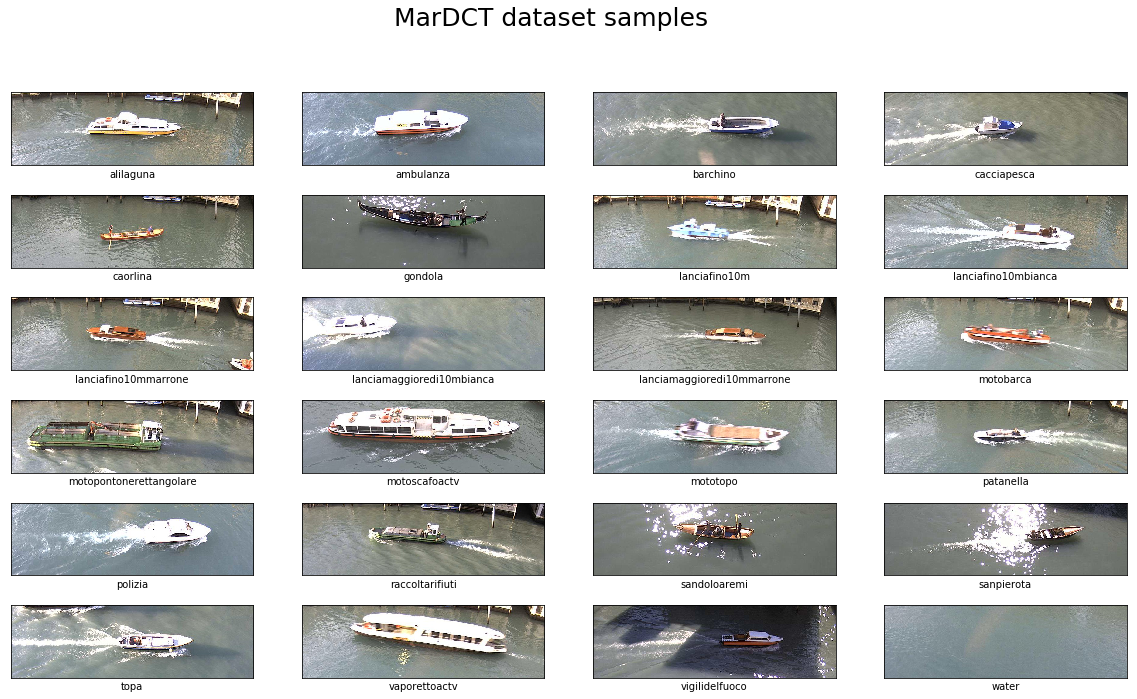

In [3]:
fig = plt.figure(figsize=(20,11))
fig.suptitle('MarDCT dataset samples', fontsize=25)
i = 0
for folder in train_labels:
    i += 1
    plt.subplot(6,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    imPath = train_path + '/' + folder
    plt.imshow(mpimg.imread(imPath + '/' + os.listdir(imPath)[0]) , cmap=plt.cm.binary)
    plt.xlabel(folder)

In [5]:
#To highlight low sampling in table
def highlight_low_sampling(val):
    try: 
        color = 'red' if val < 20 else 'black'
        return 'color: %s' % color
    except:  
        return 'color: %s' % 'black'

In the following table it is shown that some classes present in the testing set have no images in the training set, and vice versa. From this point it is clear that data augmentation should be used, since the sampling for each class is rather small, with 11 classes with less than 20 or zero images in to perform training. The whole summary of the classes and the number if images contained in each one is shown in the next table.

In [212]:
#Define counters
data = []; c1 = 0; c2 = 0 
#Count the elements in each class in training and testing set.
for label in total_labels:
    c1 = 0 if not os.path.exists(train_path +'/'+ label) else len(os.listdir(train_path +'/'+ label))
    c2 = 0 if not os.path.exists(test_path +'/'+ label) else len(os.listdir(test_path +'/'+ label))
    data.append((label, c1, c2))
df = pd.DataFrame(data = data, columns=['Label','Training set','Testing set'])
print("Classes with less than 20 images for training: " + str(len(df[df['Training set'] < 20])))
df.sort_values(by=['Training set'], ascending=False).style.applymap(highlight_low_sampling)


Classes with less than 20 images for training: 11


,Label,Training set,Testing set
24,vaporettoactv,949,325
26,water,907,420
16,mototopo,878,274
9,lanciafino10mbianca,484,217
10,lanciafino10mmarrone,355,125
18,patanella,279,74
13,motobarca,215,59
0,alilaguna,113,19
4,barchino,112,51
20,raccoltarifiuti,94,19


The following Venn diagram depicts that only 19 categories contain data in both sets, showing also 8 classes being exclusive in those sets. The considerable difference of sampling between classes is shown in the bar chart below.

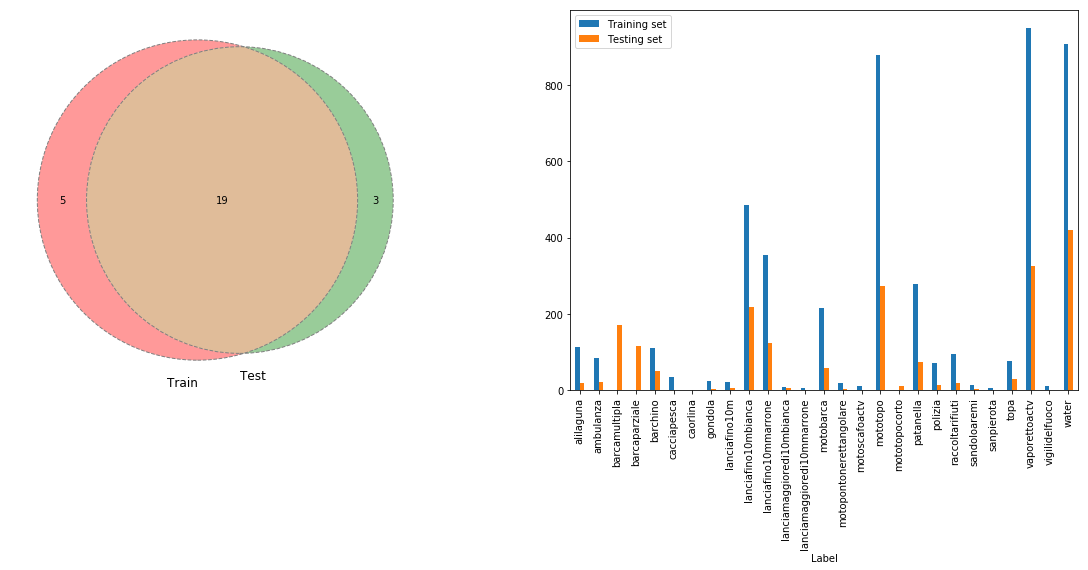

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20, 7)
df.plot(ax = ax[1], kind = 'bar', x = 'Label')
v=venn2([set(train_labels), set(test_labels)], set_labels = ('Train', 'Test'),ax=ax[0])
c=venn2_circles([set(train_labels), set(test_labels)], linestyle='dashed', linewidth=1, color="grey",ax=ax[0])

# Problem definition
In this supervised learning scenario, this work intends to classify the specific category of the given set of images belonging to the [MarDT database](http://www.dis.uniroma1.it/~labrococo/MAR/classification.htm). It will be performed in the classes that contain samples in both training and testing set, which is 19 classes.

# Solutions

Two approaches are explored: a deep feature extractor with a convolutional neural network (CNN) with a Support Vector Machine (SVM) classifier; and a deep learning classifier only. The well-known libraries Tensorflow and Keras are used.

Given the little quantity of samples of some classes, a pretrained model is considered. In this case, the VGG16 model from Keras will be used, which was originally trained with images with dimensions 224 x 224. In order to match the proper input, our images will be converted to this size.

Below, the preprocessing of the data is performed, which is common to both approaches.

In [39]:
#Select categories with samples different than zero
filt = np.logical_and(list(df['Testing set'] != 0) , list(df['Training set'] != 0))
df_filter = df[filt].reset_index(drop=True)

In [40]:
#Classes taken into consideration.
df_filter

,Label,Training set,Testing set
0,alilaguna,113,19
1,ambulanza,85,22
2,barchino,112,51
3,gondola,24,3
4,lanciafino10m,22,7
5,lanciafino10mbianca,484,217
6,lanciafino10mmarrone,355,125
7,lanciamaggioredi10mbianca,9,6
8,motobarca,215,59
9,motopontonerettangolare,18,3


In [43]:
#create dictionaries to store the labels and the indexes, keeping the original ones.
index2label = dict(zip(list(df_filter.index),list(df_filter.Label)))
label2index = dict(zip(list(df_filter.Label),list(df_filter.index)))
labels = list(df_filter['Label'])
label2index

{'alilaguna': 0,
 'ambulanza': 1,
 'barchino': 2,
 'gondola': 3,
 'lanciafino10m': 4,
 'lanciafino10mbianca': 5,
 'lanciafino10mmarrone': 6,
 'lanciamaggioredi10mbianca': 7,
 'motobarca': 8,
 'motopontonerettangolare': 9,
 'motoscafoactv': 10,
 'mototopo': 11,
 'patanella': 12,
 'polizia': 13,
 'raccoltarifiuti': 14,
 'sandoloaremi': 15,
 'topa': 16,
 'vaporettoactv': 17,
 'water': 18}

## Approach 1: Deep learning classifier

### Trained from zero
A Convolutional Neural Network with data augmentation is designed, which is going to be called in this work _Model 1_. It holds an input layer of 224 x 224. A five-set of three 2D convolutional layers is added to a sequential model, with a 5 x 5 kernel and 32 filters each, followed by a Relu activation function, and a 2 x 2 Max Pooling layer, that reduces the matrix in a factor of two. The summary of this model and with the respective layer sized in each step is shown in the following pieces of code.
Several parts of the following codes were helped by the information in [this blog](https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/).

In [10]:
# Create the model
model1 = models.Sequential()

# Add new layers
model1.add(layers.Conv2D(filters = 32 ,  padding="same",kernel_size=[5, 5],input_shape=(img_size, img_size, 3)))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Activation("relu"))
model1.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Activation("relu"))
model1.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Activation("relu"))
model1.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Activation("relu"))
model1.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Conv2D(filters = 32, kernel_size=[5, 5], padding = "same"))
model1.add(layers.Activation("relu"))
model1.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1.add(layers.Flatten())# this converts our 3D feature maps to 1D feature vectors
model1.add(layers.Dense(1024, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(df_filter), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      25632     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      25632     
__________

In [15]:
# Data Augmentation is defined, in order to increase the number of samples analyzed
print("[INFO] Defining Image generators...")
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 10
test_batchsize = 10

print("[INFO] Defining data generators")
# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_size, img_size),
        classes = list(df_filter['Label']),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
test_generator = validation_datagen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        classes = labels,
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

print("[INFO] Compile the model...")
# Compile the model
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
print("[INFO] Done.")


[INFO] Defining Image generators...
[INFO] Defining data generators
Found 4717 images belonging to 19 classes.
Found 1672 images belonging to 19 classes.
[INFO] Compile the model...
[INFO] Done.


In [77]:
def plotCurvesEval(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
def plotErrors(num_im, predictions, errors):
    print("Printing only the first "+ str(num_im) +" miss classified images.")
    # Show the errors
    for i in range(num_im):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = index2label[pred_class]

        title = 'Original label: {} --- Prediction: {} --- confidence: {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(test_path,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

[INFO] Training the model...
Epoch 1/50
472/471 [==============================] - 95s 201ms/step - loss: 1.7378 - acc: 0.4942 - val_loss: 1.1373 - val_acc: 0.6788
Epoch 2/50
472/471 [==============================] - 93s 197ms/step - loss: 1.2212 - acc: 0.6566 - val_loss: 0.8707 - val_acc: 0.7512
Epoch 3/50
472/471 [==============================] - 96s 204ms/step - loss: 1.0202 - acc: 0.7161 - val_loss: 0.8655 - val_acc: 0.7835
Epoch 4/50
472/471 [==============================] - 97s 206ms/step - loss: 0.9237 - acc: 0.7459 - val_loss: 0.7968 - val_acc: 0.7805
Epoch 5/50
472/471 [==============================] - 95s 201ms/step - loss: 0.8284 - acc: 0.7699 - val_loss: 0.6209 - val_acc: 0.8289
Epoch 6/50
472/471 [==============================] - 95s 201ms/step - loss: 0.7692 - acc: 0.7828 - val_loss: 0.6344 - val_acc: 0.8391
Epoch 7/50
472/471 [==============================] - 96s 203ms/step - loss: 0.7704 - acc: 0.7835 - val_loss: 0.6251 - val_acc: 0.8260
Epoch 8/50
472/471 [======

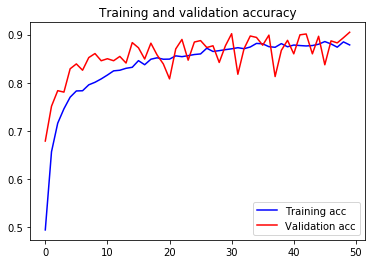

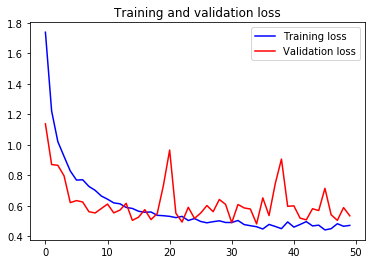

In [17]:
print("[INFO] Training the model...")
# Train the Model
history_model1 = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=test_generator,
      validation_steps=test_generator.samples/test_generator.batch_size,
      verbose=1)
model1.save('model1.h5')
plotCurvesEval(history_model1)

Found 1672 images belonging to 19 classes.
168/167 [==============================] - 8s 47ms/step
Number of errors = 159/1672
Printing only the first 5 miss classified images.


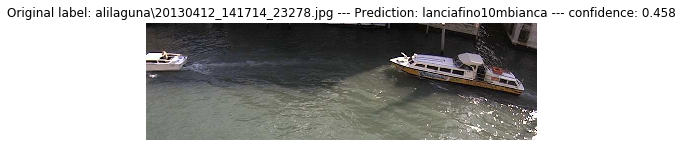

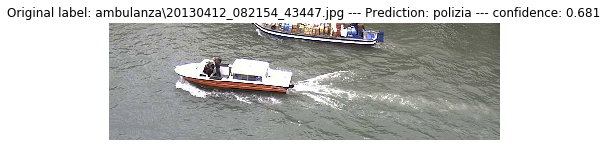

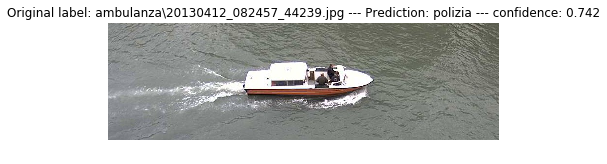

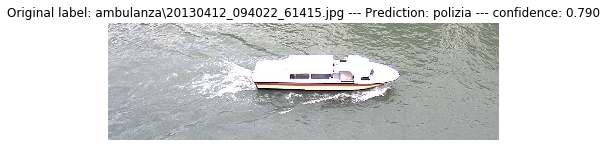

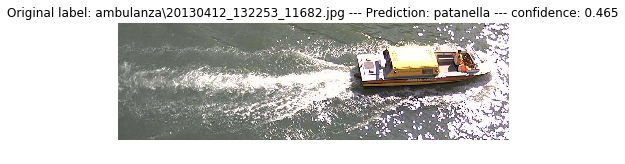

In [78]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        classes = labels,
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the predictions from the model using the generator
predictions_model1 = model1.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes_model1 = np.argmax(predictions_model1,axis=1)

errors = np.where(predicted_classes_model1 != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
plotErrors(5 if len(errors) > 5 else len(errors), predictions_model1, errors)


The previous results show a fair classification, that reaches 90% of accuracy. This might be due to some of the low sampling and the network configuration. Also, the training from scratch takes more time to converge to acceptable results. 

### Using a pretrained model

To focus the training in some of the specific shapes of the vehicles, a pretrained model is considered as the first layers of the model. The [VGG16 model](https://arxiv.org/abs/1409.1556), with weights pre-trained on ImageNet, is a convenient option with deep 18 layers trained to generalize the identification in other datasets. 

The VGG16 model is loaded below, and a sequential model is built on top of it, to add the final layers of the sequence.

In [30]:
# Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
                 
# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model_pre_tr = models.Sequential()

# Add the vgg convolutional base model
model_pre_tr.add(vgg_conv)

# Add new layers
model_pre_tr.add(layers.Flatten())
model_pre_tr.add(layers.Dense(1024, activation='relu'))
model_pre_tr.add(layers.Dropout(0.5))
model_pre_tr.add(layers.Dense(len(df_filter), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model_pre_tr.summary()

<keras.engine.input_layer.InputLayer object at 0x00000253C0455978> False
<keras.layers.convolutional.Conv2D object at 0x00000253C04559E8> False
<keras.layers.convolutional.Conv2D object at 0x00000253C0455A20> False
<keras.layers.pooling.MaxPooling2D object at 0x00000253C200AE10> False
<keras.layers.convolutional.Conv2D object at 0x00000253C200AB00> False
<keras.layers.convolutional.Conv2D object at 0x00000253C045F4A8> False
<keras.layers.pooling.MaxPooling2D object at 0x00000253C158EC50> False
<keras.layers.convolutional.Conv2D object at 0x00000253C158EAC8> False
<keras.layers.convolutional.Conv2D object at 0x00000253C1611DA0> False
<keras.layers.convolutional.Conv2D object at 0x00000253C162F828> False
<keras.layers.pooling.MaxPooling2D object at 0x00000253C1773908> False
<keras.layers.convolutional.Conv2D object at 0x00000253C1773390> False
<keras.layers.convolutional.Conv2D object at 0x00000253C1E7FDA0> False
<keras.layers.convolutional.Conv2D object at 0x00000253C1E74828> False
<ker

In [31]:
#Initialization of parameters and model compiling is performed again
print("[INFO] Defining Image generators...")
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 10
test_batchsize = 10

print("[INFO] Defining data generators")
# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_size, img_size),
        classes = list(df_filter['Label']),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
test_generator = validation_datagen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        classes = labels,
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

print("[INFO] Compile the model...")
# Compile the model
model_pre_tr.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['mae', 'acc'])
print("[INFO] Done.")


[INFO] Defining Image generators...
[INFO] Defining data generators
Found 4717 images belonging to 19 classes.
Found 1672 images belonging to 19 classes.
[INFO] Compile the model...
[INFO] Done.


[INFO] Training the model...
Epoch 1/50
472/471 [==============================] - 114s 242ms/step - loss: 0.9899 - mean_absolute_error: 0.0359 - acc: 0.7401 - val_loss: 0.6507 - val_mean_absolute_error: 0.0278 - val_acc: 0.8236loss: 1.0081 - mean_absolute_error: 0
Epoch 2/50
472/471 [==============================] - 111s 236ms/step - loss: 0.6097 - mean_absolute_error: 0.0224 - acc: 0.8389 - val_loss: 0.7156 - val_mean_absolute_error: 0.0154 - val_acc: 0.8696
Epoch 3/50
472/471 [==============================] - 112s 237ms/step - loss: 0.5284 - mean_absolute_error: 0.0188 - acc: 0.8616 - val_loss: 0.5433 - val_mean_absolute_error: 0.0153 - val_acc: 0.8989
Epoch 4/50
472/471 [==============================] - 111s 235ms/step - loss: 0.4593 - mean_absolute_error: 0.0160 - acc: 0.8853 - val_loss: 0.5803 - val_mean_absolute_error: 0.0140 - val_acc: 0.8840
Epoch 5/50
472/471 [==============================] - 111s 234ms/step - loss: 0.4442 - mean_absolute_error: 0.0147 - acc: 0.8925 - val

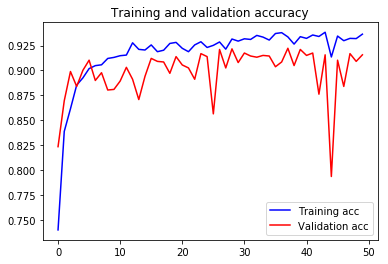

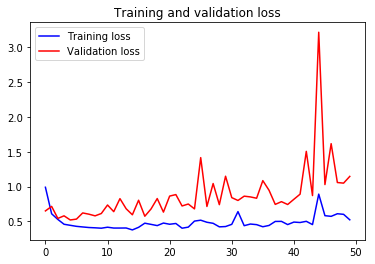

In [32]:
print("[INFO] Training the model...")
# Train the Model
history_model_pretrained = model_pre_tr.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=test_generator,
      validation_steps=test_generator.samples/test_generator.batch_size,
      verbose=1)

model_pre_tr.save('model_pretrained.h5')

#Plot the curves of the obtained metrics 
plotCurvesEval(history_model_pretrained)

Curves above show a highly correlated dynamic between training and validation, that shows some signs of over-training on data. Still, accuracy reaches values above 90%, which is considered a good match.

Found 1672 images belonging to 19 classes.
168/167 [==============================] - 21s 124ms/step
Number of errors = 141/1672
Printing only the first five miss classified images.


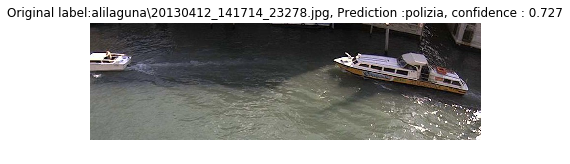

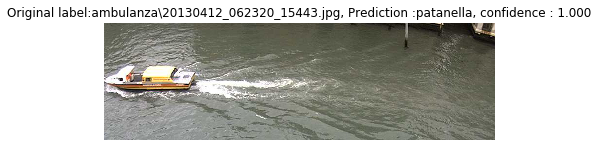

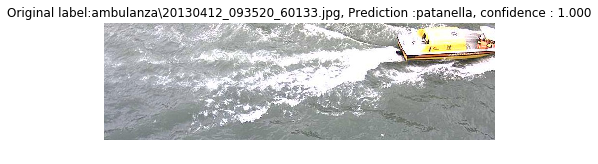

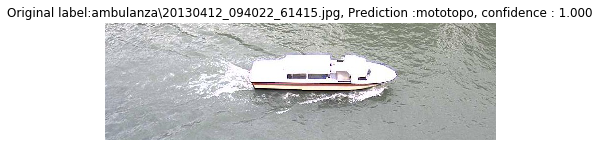

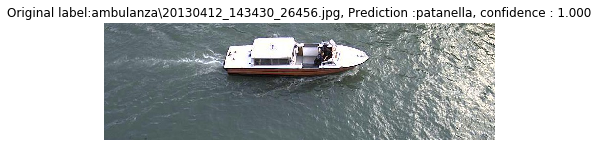

In [67]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        test_path,
        classes = labels,
        target_size=(img_size, img_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the predictions from the model using the generator
predictions_model_pretrained = model_pre_tr.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes_pre_trained = np.argmax(predictions_model_pretrained,axis=1)

errors = np.where(predicted_classes_pre_trained != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))

plotErrors(5 if len(errors) > 5 else len(errors), predictions_model_pretrained, errors)

## Approach 2: Deep features + classifier



To evaluate the performance of some other supervised classification algorithms, the previous VGG16 model, which showed to have slightly better results that the first model, will be used as a feature extractor with and additional flatten layer. From this configuration, a 1024-element vector per each image will be extracted. The resulting array shall be input of the classifier, developed as follows.

In [53]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

modelvgg16 = models.Sequential()

modelvgg16.add(vgg_conv)
# Add new layers
modelvgg16.add(layers.Flatten())
modelvgg16.add(layers.Dense(1024, activation='relu'))
modelvgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              25691136  
Total params: 40,405,824
Trainable params: 40,405,824
Non-trainable params: 0
_________________________________________________________________


The following functions extract the features of each image by passing them through the neural network, building an array of the information of the elements. Also, a shuffling in the training set is performed, since it is not handled automatically, like in Keras library.

In [56]:
#%%
def getDataFromFolder(path, classes, tag = ""):
    print("[INFO] (" + tag + ") Start. Reading data from folder...")
    X = []
    Y = []
    for idx, folder in enumerate(classes):
        files = os.listdir(path + '/' + folder)
        print("[INFO] (" + tag + ") "+str(idx+1)+". Category: "+ folder + " (" + str(len(files)) + ").")
        for file in files:
            img = image.load_img('{}/{}'.format(path,folder + '/'+ file), target_size=(img_size, img_size))
            img_data = image.img_to_array(img) 
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)    
            vgg16_feature = modelvgg16.predict(img_data)
            X.append(np.array(vgg16_feature[0]))
            Y.append(label2index[folder])
            #np.vstack((X, np.array(vgg16_feature[0])))
            #np.vstack((Y,label2index[folder]))
    print("[INFO] (" + tag + ") Reading completed. \n")
    return np.array(X), np.array(Y)
    
def shuffleArray(arr1,arr2): 
    #list1 and list2 have the same dimensions
    pivot = list(zip(arr1, arr2))
    random.shuffle(pivot)
    arrsh1, arrsh2 = list(zip(*pivot))
    return np.array(arrsh1), np.array(arrsh2)

In [57]:
train_data, train_labels = getDataFromFolder(train_path,list(df_filter['Label']), "Train")
test_data, test_labels = getDataFromFolder(test_path, list(df_filter['Label']), "Test")

[INFO] (Train) Start. Reading data from folder...
[INFO] (Train) 1. Category: alilaguna (113).
[INFO] (Train) 2. Category: ambulanza (85).
[INFO] (Train) 3. Category: barchino (112).
[INFO] (Train) 4. Category: gondola (24).
[INFO] (Train) 5. Category: lanciafino10m (22).
[INFO] (Train) 6. Category: lanciafino10mbianca (484).
[INFO] (Train) 7. Category: lanciafino10mmarrone (355).
[INFO] (Train) 8. Category: lanciamaggioredi10mbianca (9).
[INFO] (Train) 9. Category: motobarca (215).
[INFO] (Train) 10. Category: motopontonerettangolare (18).
[INFO] (Train) 11. Category: motoscafoactv (11).
[INFO] (Train) 12. Category: mototopo (878).
[INFO] (Train) 13. Category: patanella (279).
[INFO] (Train) 14. Category: polizia (71).
[INFO] (Train) 15. Category: raccoltarifiuti (94).
[INFO] (Train) 16. Category: sandoloaremi (13).
[INFO] (Train) 17. Category: topa (78).
[INFO] (Train) 18. Category: vaporettoactv (949).
[INFO] (Train) 19. Category: water (907).
[INFO] (Train) Reading completed. 

[IN

In [81]:
print("Shuffling the samples for fitting...")
train_data, train_labels= shuffleArray(train_data,train_labels)

Shuffling the samples for fitting...


In [82]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Scikit-learn library will be used to provide the background of the models. A quick fitting of the following classification algorithms is performed:

- Logistic Regresion
- Linear discriminant Analysis
- K-Nearest neighbors
- Random Forest
- Support Vector Machines (Linear kernel)
- Support Vector Machines (Poly kernel)
- Support Vector Machines (Radial basis function kernel)

Accordingly, the predicted labels of these models are contrasted to the ground truth to evaluate the accuracy of it.

In [83]:
#Additional imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score, classification_report
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

In [84]:
modelsClf = []
modelsClf.append(('Logistic Regression', LogisticRegression(random_state=9)))
modelsClf.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
modelsClf.append(('KNN', KNeighborsClassifier()))
modelsClf.append(('Random Forest', RandomForestClassifier(n_estimators=100, random_state=9)))
modelsClf.append(('Support Vector Machines (Linear)', SVC(random_state=9, kernel = 'linear', gamma = 'auto')))
modelsClf.append(('Support Vector Machines (Poly)', SVC(random_state=9, kernel = 'poly', gamma = 'auto')))
modelsClf.append(('Support Vector Machines (Radial Basis Function)', SVC(random_state=9, kernel = 'rbf', gamma = 'auto')))

In [85]:
#Fitting of the models
for name, model in modelsClf:
    print("[INFO] Training classifier: " + name + "...")
    model.fit(train_data, train_labels)
print("[INFO] Training completed. \n")

[INFO] Training classifier: Logistic Regression...
[INFO] Training classifier: Linear Discriminant Analysis...
[INFO] Training classifier: KNN...
[INFO] Training classifier: Random Forest...
[INFO] Training classifier: Support Vector Machines (Linear)...
[INFO] Training classifier: Support Vector Machines (Poly)...
[INFO] Training classifier: Support Vector Machines (Radial Basis Function)...
[INFO] Training completed. 



In [86]:
#Testing the classification models.
test_pred = []
for name, model in modelsClf:
    print("[INFO] Testing classifier: " + name + "...")
    test_pred.append(model.predict(test_data))
print("Testing completed. \n")

[INFO] Testing classifier: Logistic Regression...
[INFO] Testing classifier: Linear Discriminant Analysis...
[INFO] Testing classifier: KNN...
[INFO] Testing classifier: Random Forest...
[INFO] Testing classifier: Support Vector Machines (Linear)...
[INFO] Testing classifier: Support Vector Machines (Poly)...
[INFO] Testing classifier: Support Vector Machines (Radial Basis Function)...
Testing completed. 



# Results
In total, 8 models were processed, ordered by accuracy in the table below. The Convolutional Neural Network with the pre-trained model shows to have the best results overall, but with the other approaches very close. A remarkable number is the low performance of SVM classifier with Radial Basis Function kernel, which achieves not even a 30% accuracy. In this data set, in the configuration of the features extracted by the CNN, that kernel performs very poorly.

The classifiers based on CNN outperform the other classifiers, but it should be taken into account that these other methods can be improved by tunning of parameters in each particular method. Additionally, a considerable difference is that data augmentation was not implemented in this second-part approach, therefore lower results are expected. However, even with these change, good output was achieved.

Confusion matrix and the Scikit-learn Classification report are good are computed below.

In [203]:
#Evaluating the classifications.
test_results = []
print("[INFO] Getting evaluation metrics...")
for idx, preds in enumerate(test_pred):
    stats = [modelsClf[idx][0]] #Name of the classifier
    stats.append(accuracy_score(test_labels, preds))
    stats.append(hamming_loss(test_labels, preds))    
    test_results.append(stats)
print("Evaluation completed. \n")

[INFO] Getting evaluation metrics...
Evaluation completed. 



In [99]:
test_results.insert(0,['CNN Pre-trained',accuracy_score(test_labels,predicted_classes_pre_trained),hamming_loss(test_labels, predicted_classes_pre_trained)])
test_results.insert(0,['CNN Model 1',accuracy_score(test_labels,predicted_classes_model1),hamming_loss(test_labels, predicted_classes_model1)])

In [102]:
results = pd.DataFrame(data = test_results, columns=['Classifier','Accuracy','Loss'])
results.sort_values(by=['Accuracy'], ascending=False)

,Classifier,Accuracy,Loss
1,CNN Pre-trained,0.915670,0.084330
0,CNN Model 1,0.904904,0.095096
7,Support Vector Machines (Poly),0.859450,0.140550
6,Support Vector Machines (Linear),0.853469,0.146531
3,Linear Discriminant Analysis,0.840909,0.159091
2,Logistic Regression,0.832536,0.167464
4,KNN,0.807416,0.192584
5,Random Forest,0.775718,0.224282
8,Support Vector Machines (Radial Basis Function),0.295455,0.704545


In [111]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
cm = sns.light_palette("green", as_cmap=True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    cmap.set_under(color='white')    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin = '1')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


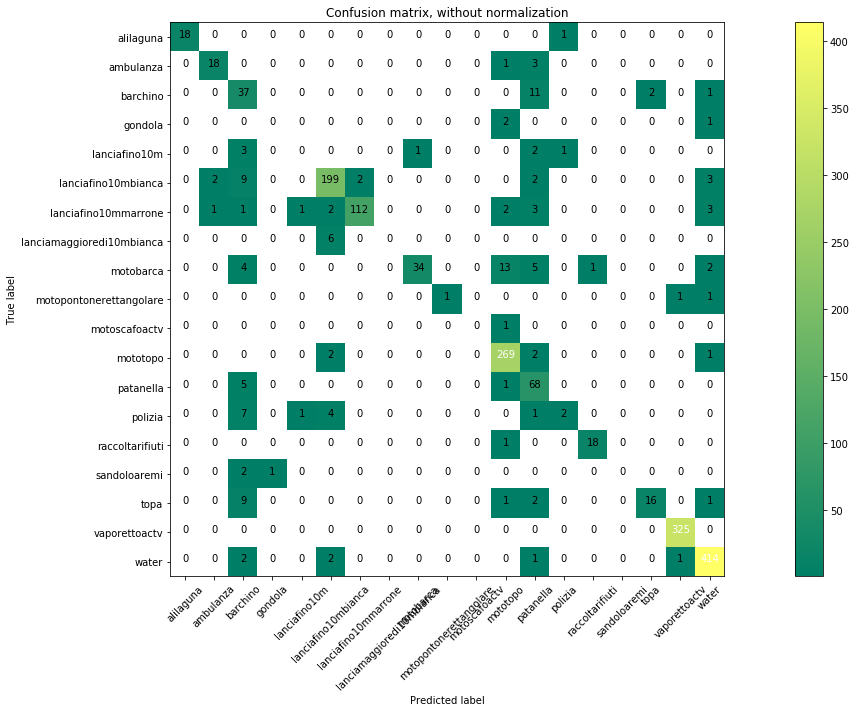

In [194]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted_classes_pre_trained)
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

In [205]:
pd.DataFrame(classification_report(test_labels, predicted_classes_pre_trained, target_names=list(df_filter["Label"]), output_dict=True)).T.sort_values(by=['recall'])

D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,f1-score,precision,recall,support
motoscafoactv,0.000000,0.000000,0.000000,1.0
gondola,0.000000,0.000000,0.000000,3.0
lanciafino10m,0.000000,0.000000,0.000000,7.0
lanciamaggioredi10mbianca,0.000000,0.000000,0.000000,6.0
sandoloaremi,0.000000,0.000000,0.000000,3.0
polizia,0.210526,0.500000,0.133333,15.0
motopontonerettangolare,0.500000,1.000000,0.333333,3.0
topa,0.680851,0.888889,0.551724,29.0
macro avg,0.579391,0.637319,0.564869,1672.0
motobarca,0.723404,0.971429,0.576271,59.0


Confusion matrix and the tool Scikit-learn classification report above are good resources to analyze which classes presented the highest inaccuracy when categorized. These are processed for the best classifier only.
The six groups with lowest items in the testing set, shown in column 'support', were misclassified. Classes like 'barchino' and 'motobarca' show a poor classification rate, with lower than 60% of success, that lead to an inspection of the images in the folders to check the reason of the mismatches.
It was found that the ground truth is not very definitive in several cases, given some vehicles that were originally misclassified in the test set by the human labeler, as shown in the examples below. Therefore, a perfect classification scenario cannot be expected due to noise in the referenced items.

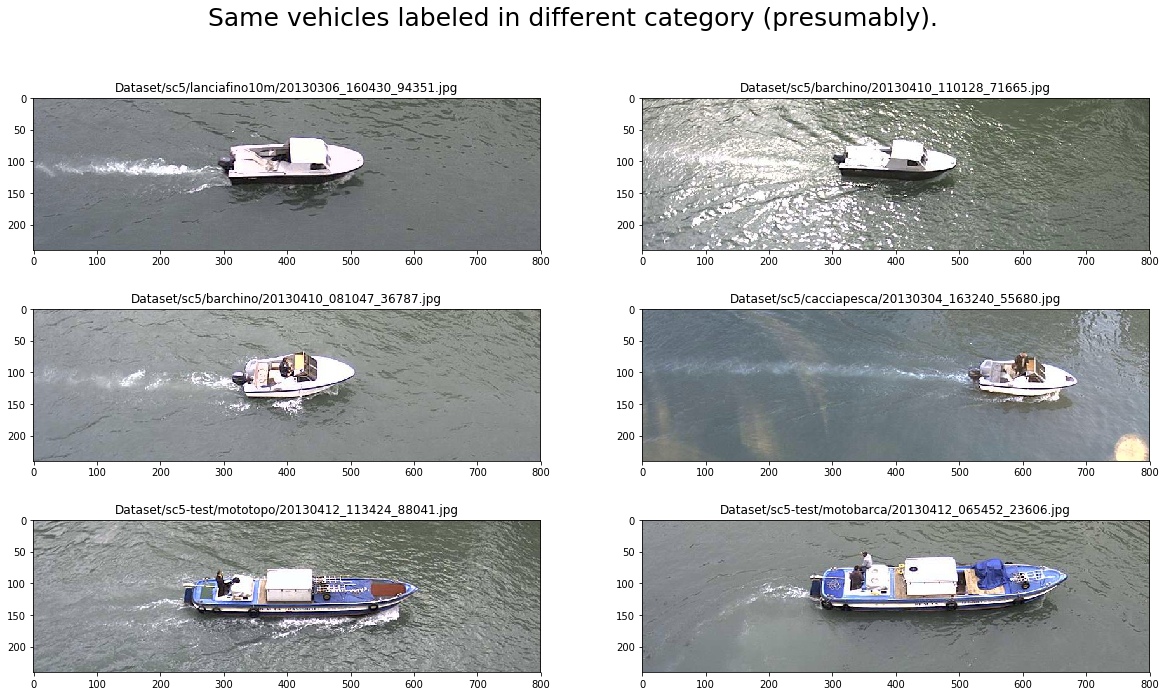

In [27]:
test_path = base_path + '/' + 'sc5-test'

imagesToCompare = [train_path+'/'+'lanciafino10m/20130306_160430_94351.jpg',
                   train_path+'/'+'barchino/20130410_110128_71665.jpg',
                   train_path+'/'+'barchino/20130410_081047_36787.jpg',
                   train_path+'/'+'cacciapesca/20130304_163240_55680.jpg',
                   test_path+'/'+'mototopo/20130412_113424_88041.jpg',
                   test_path+'/'+'motobarca/20130412_065452_23606.jpg']

fig = plt.figure(figsize=(20,11))
fig.suptitle('Same vehicles labeled in different category (presumably).', fontsize=25)

for i in range(6):
    plt.subplot(320 + i + 1,title=imagesToCompare[i])
    plt.imshow(mpimg.imread(imagesToCompare[i]))
plt.show()

# Conclusions

The use of the CNN-based methods can be highly recommended in this classification task, as it showed the best results overall. However, several changes might be applied to improve the other processed methods. With respect to data, due to the very low sampling in some classes, it is highly suggested to use data augmentation to increase the plurality of items, specially in the lower sampled, which should be formulated and tuned carefully, since can make big difference in the final result.

It was experimentally shown that ground truth in general has some inconsistence regarding setting labels in some images, which implies that the classification process cannot reach a 100% success rate in any deterministic scenario. Nonetheless, in a more general category, not specific, it should assign the label favorably.

